In [ ]:
https://raw.githubusercontent.com/benoitparis/explainable-challenge/master/heloc_dataset_v1.csv

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [18]:

from sklearn.linear_model import LogisticRegression

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

In [46]:
df=pd.read_csv("heloc_dataset_v1.csv",sep=",")

In [47]:
variable_names = list(df.columns[1:])
X = df[variable_names]

In [48]:
target = "RiskPerformance"
y = df[target].values
mask = y == "Bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(int)

### 特殊值处理

-9 没有局记录或没有调查 

-8 没有可用/有效的交易或查询

-7 未满足条件（例如，无查询、无拖欠）

In [34]:
special_codes = [-9, -8, -7]

根据信息价值 (IV) 预测性和最低质量分数指定选择标准，以去除低质量变量。然后，我们BinningProcess用变量名、特殊代码和选择标准来实例化一个对象类

In [36]:
selection_criteria = {
    "iv": {"min": 0.02, "max": 1},
    "quality_score": {"min": 0.01}
}

In [37]:
binning_process = BinningProcess(variable_names, special_codes=special_codes,
                                 selection_criteria=selection_criteria)

我们选择使用非线性求解器 L-BFGS-B 求解的逻辑回归作为估计量

In [38]:
estimator = LogisticRegression(solver="lbfgs")

最后，我们Scorecard用目标名称、分箱过程对象和估计器实例化一个类。此外，我们希望对记分卡点应用缩放方法。

In [41]:
scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

In [49]:
scorecard.fit(X, y)

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02},
                                                             'quality_score': {'min': 0.01}},
                                         special_codes=[-9, -8, -7],
                                         variable_names=['ExternalRiskEstimate',
                                                         'MSinceOldestTradeOpen',
                                                         'MSinceMostRecentTradeOpen',
                                                         'AverageMInFile',
                                                         'NumSatisfactoryTrades',
                                                         'NumTrades60Ever2DerogPubRec',
                                                         'NumTrades90Ever2DerogPubRec',
                                                         'PercentTradesNe...
                                                         'PercentInstallTrades',
                                                         'MSinceMostRecentInqexcl7days',
                                                         'NumInqLast6M',
                                                         'NumInqLast6Mexcl7days',
                                                         'NetFractionRevolvingBurden',
                                                         'NetFractionInstallBurden',
                                                         'NumRevolvingTradesWBalance',
                                                         'NumInstallTradesWBalance',
                                                         'NumBank2NatlTradesWHighUtilization',
                                                         'PercentTradesWBalance']),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

In [50]:
scorecard.information(print_level=2)

optbinning (Version 0.14.1)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                  10459
    Number of variables                   23
    Target type                       binary

    Number of numerical                   23
    Number of categorical                  0
    Number of selected                    19

  Timing
    Total time                          2.09 sec
    Binning process                     1.94 sec   ( 92.75%)
    Estimator                           0.08 sec   (  3.73%

In [52]:
scorecard.table(style="summary")

,Variable,Bin,Points
0,ExternalRiskEstimate,"(-inf, 59.50)",5.359275
1,ExternalRiskEstimate,"[59.50, 63.50)",11.598078
2,ExternalRiskEstimate,"[63.50, 65.50)",18.168973
3,ExternalRiskEstimate,"[65.50, 67.50)",19.821705
4,ExternalRiskEstimate,"[67.50, 70.50)",25.498720
...,...,...,...
8,PercentTradesWBalance,"[80.50, 87.50)",32.310289
9,PercentTradesWBalance,"[87.50, 98.00)",32.026880
10,PercentTradesWBalance,"[98.00, inf)",31.928758
11,PercentTradesWBalance,Special,32.738612


In [53]:
scorecard.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,ExternalRiskEstimate,0,"(-inf, 59.50)",1081,0.103356,166,915,0.846438,-1.619109,0.217629,0.024574,-0.327969,5.359275
1,ExternalRiskEstimate,1,"[59.50, 63.50)",1097,0.104886,228,869,0.792160,-1.250170,0.142003,0.016678,-0.327969,11.598078
2,ExternalRiskEstimate,2,"[63.50, 65.50)",681,0.065111,190,491,0.720999,-0.861592,0.044754,0.005427,-0.327969,18.168973
3,ExternalRiskEstimate,3,"[65.50, 67.50)",652,0.062339,195,457,0.700920,-0.763856,0.034156,0.004169,-0.327969,19.821705
4,ExternalRiskEstimate,4,"[67.50, 70.50)",1038,0.099245,388,650,0.626204,-0.428139,0.017755,0.002203,-0.327969,25.498720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,PercentTradesWBalance,8,"[80.50, 87.50)",797,0.076202,283,514,0.644918,-0.508949,0.019114,0.002364,-0.016322,32.310289
9,PercentTradesWBalance,9,"[87.50, 98.00)",652,0.062339,184,468,0.717791,-0.845705,0.041380,0.005024,-0.016322,32.026880
10,PercentTradesWBalance,10,"[98.00, inf)",1277,0.122096,331,946,0.740799,-0.962296,0.103054,0.012407,-0.016322,31.928758
11,PercentTradesWBalance,11,Special,606,0.057941,269,337,0.556106,-0.137544,0.001091,0.000136,-0.016322,32.738612


In [54]:
sc = scorecard.table(style="summary")
sc.groupby("Variable").agg({'Points' : [np.min, np.max]}).sum()

Points  amin    300.0
        amax    850.0
dtype: float64

In [59]:
sc.groupby("Variable").agg({"Points":["max","min"]}).sum()

Points  max    850.0
        min    300.0
dtype: float64

In [64]:
sc.Variable.nunique()

19

### 评分卡表现 

In [68]:
y_pred = scorecard.predict_proba(X)[:, 1]

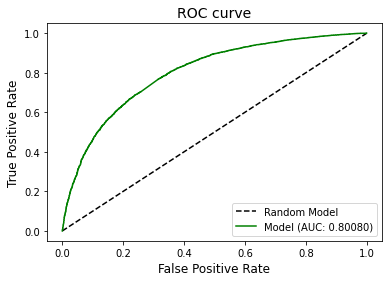

In [69]:
plot_auc_roc(y, y_pred)

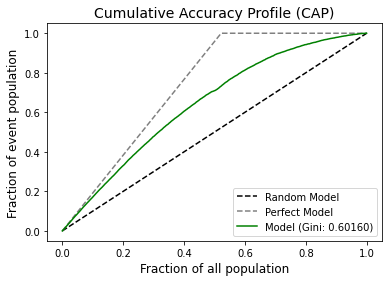

In [72]:
plot_cap(y, y_pred)  # 绘制累积准确度配置文件 (CAP)

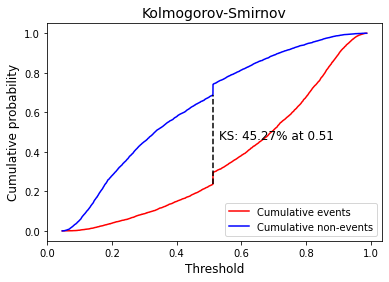

In [71]:
plot_ks(y, y_pred)

计算数据集的分数并绘制事件和非事件记录的分数分布。

分数转换

In [76]:
score = scorecard.score(X)

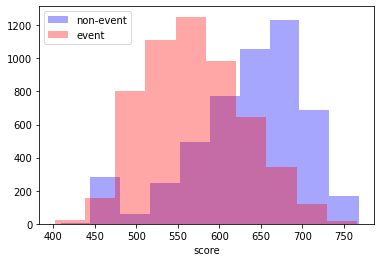

In [77]:
mask = y == 0
plt.hist(score[mask], label="non-event", color="b", alpha=0.35)
plt.hist(score[~mask], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

### 记分卡监控

In [78]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import ScorecardMonitoring

In [80]:
df = pd.read_csv("heloc_dataset_v1.csv", sep=",")

variable_names = list(df.columns[1:])

target = "RiskPerformance"
y = df[target].values
mask = y == "Bad"
y[mask] = 1
y[~mask] = 0
y = y.astype(int)

X = df[variable_names]

注意：实际生产环境，是具有时间序列的，所以需要根据时间轴来进行拆分数据，而非随机分割

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [84]:
special_codes = [-9, -8, -7]
selection_criteria = {
    "iv": {"min": 0.02, "max": 1},
    "quality_score": {"min": 0.01}
}

binning_process = BinningProcess(variable_names, special_codes=special_codes,
                                 selection_criteria=selection_criteria)

estimator = LogisticRegression(solver="lbfgs")

In [85]:
scorecard = Scorecard(binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 0, "max": 100})

In [86]:
scorecard.fit(X_train, y_train, metric_special="empirical", metric_missing="empirical")

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02},
                                                             'quality_score': {'min': 0.01}},
                                         special_codes=[-9, -8, -7],
                                         variable_names=['ExternalRiskEstimate',
                                                         'MSinceOldestTradeOpen',
                                                         'MSinceMostRecentTradeOpen',
                                                         'AverageMInFile',
                                                         'NumSatisfactoryTrades',
                                                         'NumTrades60Ever2DerogPubRec',
                                                         'NumTrades90Ever2DerogPubRec',
                                                         'PercentTradesNe...
                                                         'PercentInstallTrades',
                                                         'MSinceMostRecentInqexcl7days',
                                                         'NumInqLast6M',
                                                         'NumInqLast6Mexcl7days',
                                                         'NetFractionRevolvingBurden',
                                                         'NetFractionInstallBurden',
                                                         'NumRevolvingTradesWBalance',
                                                         'NumInstallTradesWBalance',
                                                         'NumBank2NatlTradesWHighUtilization',
                                                         'PercentTradesWBalance']),
          estimator=LogisticRegression(), scaling_method='min_max',
          scaling_method_params={'max': 100, 'min': 0})

In [87]:
scorecard.information(print_level=2)

optbinning (Version 0.14.1)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                   7321
    Number of variables                   23
    Target type                       binary

    Number of numerical                   23
    Number of categorical                  0
    Number of selected                    21

  Timing
    Total time                          3.83 sec
    Binning process                     3.60 sec   ( 94.00%)
    Estimator                           0.08 sec   (  2.18%

In [88]:
monitoring = ScorecardMonitoring(scorecard=scorecard, psi_method="cart",
                                 psi_n_bins=10, verbose=True)

In [89]:
monitoring.fit(X_test, y_test, X_train, y_train)

2022-05-30 15:00:49,552 | INFO : Monitoring started.
2022-05-30 15:00:49,553 | INFO : Options: check parameters.
2022-05-30 15:00:49,555 | INFO : System stability analysis started.
2022-05-30 15:00:49,788 | INFO : System stability analysis terminated. Time: 0.2318s
2022-05-30 15:00:49,789 | INFO : Variable analysis started.
2022-05-30 15:00:49,861 | INFO : Variable analysis terminated. Time: 0.0715s
2022-05-30 15:00:49,862 | INFO : Monitoring terminated. Time: 0.3103s


ScorecardMonitoring(psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                                                  'min': 0.02},
                                                                                           'quality_score': {'min': 0.01}},
                                                                       special_codes=[-9,
                                                                                      -8,
                                                                                      -7],
                                                                       variable_names=['ExternalRiskEstimate',
                                                                                       'MSinceOldestTradeOpen',
                                                                                       'MSinceMostRecentTradeOpen',
                                                                                       'AverageMInFile',
                                                                                       'NumSatisfactoryTrades',
                                                                                       'NumTrades60Ever2DerogPubRec',
                                                                                       'N...
                                                                                       'MSinceMostRecentInqexcl7days',
                                                                                       'NumInqLast6M',
                                                                                       'NumInqLast6Mexcl7days',
                                                                                       'NetFractionRevolvingBurden',
                                                                                       'NetFractionInstallBurden',
                                                                                       'NumRevolvingTradesWBalance',
                                                                                       'NumInstallTradesWBalance',
                                                                                       'NumBank2NatlTradesWHighUtilization',
                                                                                       'PercentTradesWBalance']),
                                        estimator=LogisticRegression(),
                                        scaling_method='min_max',
                                        scaling_method_params={'max': 100,
                                                               'min': 0}),
                    verbose=True)

In [90]:
monitoring.information(print_level=2)

optbinning (Version 0.14.1)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    scorecard                            yes   * U
    psi_method                          cart   * d
    psi_n_bins                            10   * U
    psi_min_bin_size                    0.05   * d
    show_digits                            2   * d
    verbose                             True   * U
  End options

  Statistics
    Number of records Actual            3138
    Number of records Expected          7321
    Number of scorecard variables         21
    Target type                       binary

  Timing
    Total time                          0.31 sec
    System stability                    0.23 sec   ( 74.70%)
    Variables stability                 0.07 sec   ( 23.05%)



In [91]:
monitoring.psi_table()

,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,"(-inf, 37.67)",158,368,0.050351,0.050266,1.408722e-07
1,"[37.67, 37.74)",174,424,0.055449,0.057916,1.073237e-04
2,"[37.74, 43.32)",295,726,0.094009,0.099167,2.754986e-04
3,"[43.32, 46.80)",293,631,0.093372,0.086190,5.746943e-04
4,"[46.80, 51.30)",389,936,0.123964,0.127851,1.200130e-04
5,"[51.30, 54.98)",343,806,0.109305,0.110094,5.674211e-06
6,"[54.98, 57.43)",207,551,0.065966,0.075263,1.225901e-03
7,"[57.43, 61.54)",385,875,0.122690,0.119519,8.300389e-05
8,"[61.54, 69.23)",648,1445,0.206501,0.197377,4.122692e-04
9,"[69.23, inf)",246,559,0.078394,0.076356,5.369279e-05


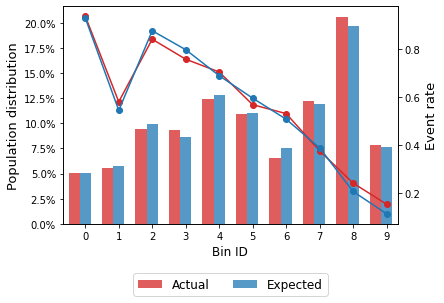

In [92]:
monitoring.psi_plot()

此分析计算统计检验，以确定列车和测试数据上的事件率是否使用卡方检验显着不同。零假设是实际 = 预期

In [93]:
monitoring.tests_table()

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"(-inf, 37.67)",158,368,0.936709,0.929348,0.093944,0.759222
1,"[37.67, 37.74)",174,424,0.580460,0.544811,0.634860,0.425578
2,"[37.74, 43.32)",295,726,0.840678,0.876033,2.256916,0.133019
3,"[43.32, 46.80)",293,631,0.757679,0.797147,1.844474,0.174427
4,"[46.80, 51.30)",389,936,0.704370,0.689103,0.301399,0.583007
5,"[51.30, 54.98)",343,806,0.568513,0.595533,0.724853,0.394557
6,"[54.98, 57.43)",207,551,0.531401,0.508167,0.325182,0.568510
7,"[57.43, 61.54)",385,875,0.376623,0.388571,0.161209,0.688046
8,"[61.54, 69.23)",648,1445,0.242284,0.207612,3.151067,0.075877
9,"[69.23, inf)",246,559,0.154472,0.114490,2.467760,0.116203


最后，该system_stability_report方法总结了整个分析过程中遇到的发现。此外，它返回与提供的记分卡在训练和测试数据上的性能的比较，以确定开发的记分卡是否在实际/演化数据上的预测能力下降。

In [94]:
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0029 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)     10        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      0        0.0
    [0.05, 0.10)      1        0.1
    [0.10, 0.50)      5        0.5
    [0.50, 1.00)      4        0.4

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records    3138          -      7321            -
        Event records    1638   0.521989      3821     0.521923
    Non-event records    1500   0.478011      3500     0.478077

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.755189  0.770741   -0.015551
     True negative rate 0.696

In [95]:

monitoring.psi_variable_table(style="detailed")

,Variable,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,ExternalRiskEstimate,"(-inf, 59.50)",494,1185,0.157425,0.161863,0.000123
1,ExternalRiskEstimate,"[59.50, 63.50)",326,771,0.103888,0.105313,0.000019
2,ExternalRiskEstimate,"[63.50, 65.50)",193,488,0.061504,0.066658,0.000415
3,ExternalRiskEstimate,"[65.50, 67.50)",205,447,0.065328,0.061057,0.000289
4,ExternalRiskEstimate,"[67.50, 70.50)",302,736,0.096240,0.100533,0.000187
...,...,...,...,...,...,...,...
5,PercentTradesWBalance,"[67.50, 73.50)",216,516,0.068834,0.070482,0.000039
6,PercentTradesWBalance,"[73.50, 75.50)",178,382,0.056724,0.052179,0.000380
7,PercentTradesWBalance,"[75.50, 84.50)",328,851,0.104525,0.116241,0.001245
8,PercentTradesWBalance,"[84.50, 89.50)",199,434,0.063416,0.059282,0.000279


In [96]:
monitoring.psi_variable_table(style="summary")

,Variable,PSI
0,AverageMInFile,0.004087
1,ExternalRiskEstimate,0.003432
2,MSinceMostRecentDelq,0.001042
3,MSinceMostRecentInqexcl7days,0.001249
4,MSinceMostRecentTradeOpen,0.000180
5,MSinceOldestTradeOpen,0.002839
6,MaxDelq2PublicRecLast12M,0.000514
7,MaxDelqEver,0.000379
8,NetFractionInstallBurden,0.003289
9,NetFractionRevolvingBurden,0.004657
